Loading and preprocessing training data...


  0%|          | 0/2 [00:00<?, ?it/s]





100%|██████████| 2/2 [06:44<00:00, 202.12s/it]



Done with preprocessing!
preparing data loaders with batch size 256
length of training data: 13314


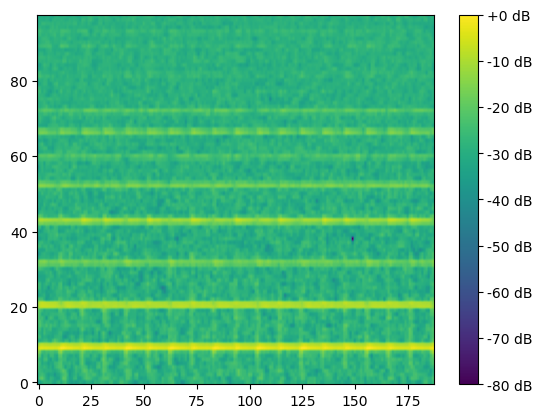

sum of dataset: 105
groundtruth:  181
bpm_librosa:  187.5
input shape syn: (98, 188)


In [6]:
# import audio_import_giantstep as aig
# import audio_import_ballroom as aib
import audio_import_syn as ais
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
import snntorch as snn
import torch
import re


batch_size = 256
files_to_load = 2000
SR =  16000 #16000 # int(22050/2)


train_set_syn, val_set_syn, input_shape_syn = ais.import_audio_get_loader(batch_size=batch_size, 
                                                             only_dataset=True, 
                                                             train_data_ratio=0.8, 
                                                             files_to_load=files_to_load,
                                                             sr=SR,
                                                             )

# train_set_giant, val_set_giant, input_shape_giant = aig.import_audio_get_loader(batch_size=batch_size, 
#                                                              only_dataset=True, 
#                                                              train_data_ratio=0.8, 
#                                                              files_to_load=150,
#                                                              sr=SR,
#                                                              )

# train_set_ball, val_set_ball, input_shape_ball = aib.import_audio_get_loader(batch_size=batch_size, 
#                                                              only_dataset=True, 
#                                                              train_data_ratio=0.9, 
#                                                              files_to_load=600,
#                                                              sr=SR,
#                                                              )

train_loader = DataLoader(train_set_syn, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_syn, batch_size=batch_size, shuffle=True)


# train_loader = DataLoader(train_set_giant+train_set_ball+train_set_syn, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set_giant+val_set_ball+val_set_syn, batch_size=batch_size, shuffle=True)


example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm = example_batch

single_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()



print(f"sum of dataset: {len(train_loader) +len(val_loader)}")
print("groundtruth: ", groundtruth[0].cpu().numpy())
print("bpm_librosa: ", librosa_bpm[0].cpu().numpy())
# print(f"input shape ball: {input_shape_ball}")
# print(f"input shape giant: {input_shape_giant}")
print(f"input shape syn: {input_shape_syn}")


input_shape = input_shape_syn



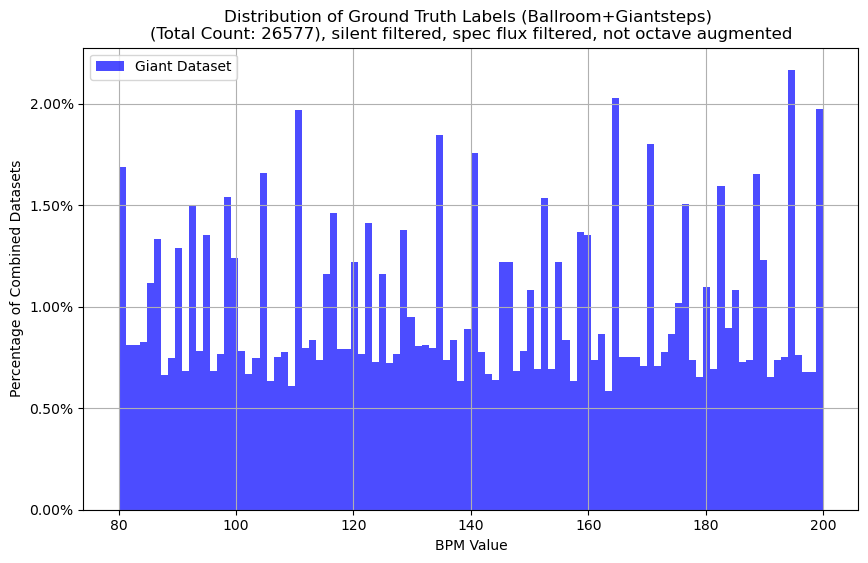

In [9]:
# Get ground truth labels and bpm_librosa directly from the datasets
all_groundtruth_giant = [item[1].item() for item in train_set_giant] + [item[1].item() for item in val_set_giant]
all_groundtruth_ball = [item[1].item() for item in train_set_ball] + [item[1].item() for item in val_set_ball]
all_groundtruth_syn = [item[1].item() for item in train_set_syn] + [item[1].item() for item in val_set_syn]

all_librosa_bpm_giant = [item[2].item() for item in train_set_giant] + [item[2].item() for item in val_set_giant]
all_librosa_bpm_ball = [item[2].item() for item in train_set_ball] + [item[2].item() for item in val_set_ball]
all_librosa_bpm_syn = [item[2].item() for item in train_set_syn] + [item[2].item() for item in val_set_syn]


# Convert lists to numpy arrays
all_groundtruth_giant = np.array(all_groundtruth_giant)
all_groundtruth_ball = np.array(all_groundtruth_ball)
all_groundtruth_syn = np.array(all_groundtruth_syn)

total_samples = len(all_groundtruth_giant) + len(all_groundtruth_ball) + len(all_groundtruth_syn)

weights_giant = np.ones_like(all_groundtruth_giant) / total_samples
weights_ball = np.ones_like(all_groundtruth_ball) / total_samples
weights_syn = np.ones_like(all_groundtruth_syn) / total_samples


plt.figure(figsize=(10, 6))

# Plotting the histograms stacked
plt.hist([all_groundtruth_giant, all_groundtruth_ball, all_groundtruth_syn], bins=100, color=['blue', 'green', 'red'], 
         alpha=0.7, label=['Giant Dataset', 'Ballroom Dataset', 'synthetic Dataset'], weights=[weights_giant, weights_ball, weights_syn], stacked=True)

plt.xlabel('BPM Value')
plt.ylabel('Percentage of Combined Datasets')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
plt.title(f'Distribution of Ground Truth Labels (Ballroom+Giantsteps) \n(Total Count: {total_samples}), silent filtered, spec flux filtered, not octave augmented')
plt.legend()
plt.grid(True)
plt.show()



In [27]:
# ...

# Identify the most frequent BPM label from both datasets combined
combined_groundtruth = np.concatenate([all_groundtruth_giant, all_groundtruth_ball])
most_frequent_bpm = np.bincount(combined_groundtruth).argmax()

# Find indices of the most frequent BPM label in each dataset
indices_to_remove_giant = np.where(all_groundtruth_giant == most_frequent_bpm)[0]
indices_to_remove_ball = np.where(all_groundtruth_ball == most_frequent_bpm)[0]

# Select 50% of those indices randomly
remove_count_giant = int(len(indices_to_remove_giant) * 0.5)
remove_count_ball = int(len(indices_to_remove_ball) * 0.5)

remove_indices_giant = np.random.choice(indices_to_remove_giant, remove_count_giant, replace=False)
remove_indices_ball = np.random.choice(indices_to_remove_ball, remove_count_ball, replace=False)

# Remove the selected samples from each dataset
train_set_giant = [item for idx, item in enumerate(train_set_giant) if idx not in remove_indices_giant]
train_set_ball = [item for idx, item in enumerate(train_set_ball) if idx not in remove_indices_ball]

# Recreate DataLoaders with the modified datasets
train_loader = DataLoader(train_set_giant + train_set_ball, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_giant + val_set_ball, batch_size=batch_size, shuffle=True)

# ... (Rest of the code remains the same)


In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# class BPMEstimator(nn.Module):
#     def __init__(self, input_shape):
#         super(BPMEstimator, self).__init__()

#         self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=(1, 1))
#         self.bn1 = nn.BatchNorm2d(32)
        
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=(1, 1))
#         self.bn2 = nn.BatchNorm2d(64)
        
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=(1, 1))
#         self.bn3 = nn.BatchNorm2d(128)

#         # Compute the size after conv and pooling layers
#         self.fc1_input_size, self.h_after_conv = self.compute_flattened_size(input_shape)
        
#         self.lstm = nn.LSTM(input_size=self.h_after_conv * 128, hidden_size=64, batch_first=True)

#         self.fc1 = nn.Linear(64, 128)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.max_pool2d(x, (2, 2))

#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.max_pool2d(x, (2, 2))

#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.max_pool2d(x, (2, 2))

#         # Prepare data for LSTM
#         batch_size, channels, height, width = x.size()
#         x = x.view(batch_size, width, -1)  # Flatten only the height and channels

#         # Pass data through LSTM
#         x, _ = self.lstm(x)

#         # Only use the last LSTM output (many-to-one RNN structure)
#         x = x[:, -1, :]

#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
        
#         return x

#     def compute_flattened_size(self, input_shape):
#         dummy_tensor = torch.ones(1, 1, *input_shape)  
#         x = self.conv1(dummy_tensor)
#         x = F.max_pool2d(x, 2)
#         x = self.conv2(x)
#         x = F.max_pool2d(x, 2)
#         x = self.conv3(x)
#         x = F.max_pool2d(x, 2)
#         _, c, h, w = x.shape
#         return c * h, h


class BPMEstimator(nn.Module):
    def __init__(self, input_shape):
        super(BPMEstimator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Compute the size after conv and pooling layers
        self.fc1_input_size = self.compute_flattened_size(input_shape)

        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # downsample by half
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # downsample by half
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def compute_flattened_size(self, input_shape):
        dummy_tensor = torch.ones(1, 1, *input_shape)  # Create a dummy batch with a batch size of 1 and 1 channel
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        _, c, h, w = x.shape
        return c * h * w




model = BPMEstimator(input_shape_syn)


criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

In [10]:
# SNN

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from snntorch import utils

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

# Set the number of OpenMP threads used by PyTorch
torch.set_num_threads(os.cpu_count())
#torch.set_num_threads(1)

def compute_input_size(H_in, W_in):
    # Assuming padding=1, kernel_size=3, stride=1 for Conv layers, and kernel_size=2 for MaxPool layers
    H_out = ((H_in + 2*1 - 3) // 1 + 1) // 2
    W_out = ((W_in + 2*1 - 3) // 1 + 1) // 2
    H_out = ((H_out + 2*1 - 3) // 1 + 1) // 2
    W_out = ((W_out + 2*1 - 3) // 1 + 1) // 2
    input_size = 64 * H_out * W_out
    return input_size


H, W = input_shape_syn
inputsize = compute_input_size(H, W)
num_classes = 200-80+1
print(inputsize)
class SpikingBPMEstimator(nn.Module):
    def __init__(self, inputsize):
        super(SpikingBPMEstimator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.Flatten(),
            nn.Dropout(0.5),  # Dropout layer with 50% dropout rate
            nn.Linear(inputsize, 128),
            nn.ReLU(),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
            nn.Linear(128, num_classes),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
        )

    def forward(self, x):
        utils.reset(self.net)  # resets hidden states for all LIF neurons in net
        
        return self.net(x)
    

# Assuming input_shape_syn is defined somewhere in your code:
model = SpikingBPMEstimator(inputsize=inputsize).to(device)

# # Training setup
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
# #loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)  # Or use nn.MSELoss() or any other loss function
# criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

72192


In [11]:
import time
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False
    
early_stopping = EarlyStopping(patience=8)

epochs = 120

batch_size_new = 256
train_loader = DataLoader(train_set_syn, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_set_syn, batch_size=batch_size_new, shuffle=True)


num_batches = len(train_loader)



start_time = time.time()
start_time_all = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    epoch_loss = 0
    correct = 0  # Correctly predicted labels
    total = 0    # Total number of labels
    model.train()
    for batch_idx, (data, target, _) in enumerate(train_loader):
        target_zero_indexed = target - 80  # Zero-indexing the labels here
        optimizer.zero_grad()
        batch_size, time_steps, channels, height, width = data.unsqueeze(1).size()
        data = data.view(batch_size, time_steps, channels, height, width)
        data = data.squeeze(1)
        outputs, _ = model(data)
        loss = criterion(outputs, target_zero_indexed)  # use zero-indexed target here
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # Calculating accuracy
        _, predicted = torch.max(outputs.data, 1)  # get the index of the max log-probability
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        print(f"Epoch {epoch + 1}/{epochs}, batch {batch_idx+1}/{num_batches} loss: {loss.item():.6f}", end='\r')
        
    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * epochs
    remaining_time = (epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total  # compute accuracy
    training_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{epochs} epochs took {end_time/60.0:.2f} mins")


Epoch 1/120, Training Loss: 4.7460, Accuracy: 2.06%, took 298.82 seconds
Estimated Total Time: 597.63 mins, Remaining Time: 592.65 mins
Epoch 2/120, Training Loss: 4.1900, Accuracy: 12.96%, took 306.00 seconds
Estimated Total Time: 612.00 mins, Remaining Time: 601.80 mins
Epoch 3/120, Training Loss: 4.0473, Accuracy: 19.89%, took 304.42 seconds
Estimated Total Time: 608.85 mins, Remaining Time: 593.63 mins
Epoch 4/120, Training Loss: 4.0032, Accuracy: 25.00%, took 307.71 seconds
Estimated Total Time: 615.43 mins, Remaining Time: 594.91 mins
Epoch 5/120, Training Loss: 3.9807, Accuracy: 27.60%, took 306.88 seconds
Estimated Total Time: 613.76 mins, Remaining Time: 588.19 mins
Epoch 6/120, Training Loss: 3.9615, Accuracy: 33.09%, took 306.11 seconds
Estimated Total Time: 612.22 mins, Remaining Time: 581.61 mins
Epoch 7/120, Training Loss: 3.9531, Accuracy: 33.91%, took 307.51 seconds
Estimated Total Time: 615.03 mins, Remaining Time: 579.15 mins
Epoch 8/120, Training Loss: 3.9455, Accura

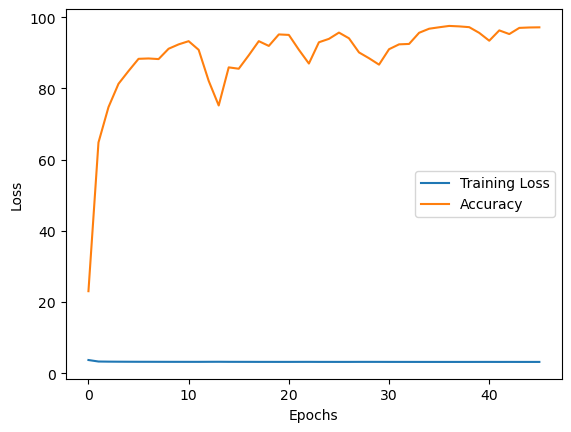

In [20]:
# Plot the loss over epochs
plt.plot(epoch_losses, label="Training Loss")
plt.plot(training_accuracies, label="Accuracy")
# plt.plot(training_mses, label="Training MSE")
# plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# load the model
model_load_path = "BPMEstimator_giantstep_ball_big_not_octave.pth"
model = BPMEstimator(input_shape)
model.load_state_dict(torch.load(model_load_path))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import time

epochs = 60

train_loader = DataLoader(train_set_syn, batch_size=256, shuffle=True, drop_last=True)

def octave_loss(outputs, target):
    half_outputs = outputs / 2
    double_outputs = outputs * 2

    loss_original = torch.abs(target - outputs)
    loss_half = torch.abs(target - half_outputs)
    loss_double = torch.abs(target - double_outputs)

    min_loss = torch.min(loss_original, torch.min(loss_half, loss_double))

    return torch.mean(min_loss)

# train_dataset = train_loader.dataset
# val_dataset = val_loader.dataset

# new_batch_size = 512  # or whatever value you want

# train_loader = DataLoader(train_dataset, batch_size=new_batch_size, shuffle=True, drop_last=False)
# val_loader = DataLoader(val_dataset, batch_size=new_batch_size, shuffle=False, drop_last=False)


start_time = time.time()
start_time_all = time.time()
for epoch in range(epochs):
    epoch_loss = 0
    training_mse = 0    
    model.train()
    for data, target, _ in train_loader:
        optimizer.zero_grad()
        print(data.shape)
        outputs = model(data).squeeze()  # Squeeze out the redundant dimension
        loss = criterion(outputs, target.float())
        # loss = octave_loss(outputs, target.float())  # Use the custom loss function
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    mean_epoch_loss = epoch_loss / len(train_loader)
    
    epoch_losses.append(mean_epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_epoch_loss:.4f}, took {time.time() - start_time:.2f} seconds")
    start_time = time.time()

    
    # # Calculate validation loss
    # model.eval()
    # with torch.no_grad():
    #     val_loss = 0
    #     for data, target in test_loader:
    #         outputs = model(data).squeeze()
    #         loss = criterion(outputs, target.float())
    #         val_loss += loss.item()
    #     mean_val_loss = val_loss / len(test_loader)
    #     validation_losses.append(mean_val_loss)

    # print(f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_epoch_loss:.4f} took {time.time() - start_time:.2f} seconds")
endtime = time.time() - start_time_all
print(f"{epochs} epochs took {endtime/60.0} mins")

# Plot the loss over epochs
plt.plot(epoch_losses, label="Training Loss")
# plt.plot(training_mses, label="Training MSE")
# plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


torch.Size([256, 1, 98, 188])


ValueError: too many values to unpack (expected 2)

In [22]:
# Save the model
model_save_path = f"CSNN_SYNDATA_{epoch}_ACC_{training_accuracies[-1]:.0f}.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to CSNN_SYNDATA_19_ACC_97.pth


In [ ]:
# load the model
model_save_path = "BPMEstimator_giantstep_big_octave.pth"
model = BPMEstimator(input_shape)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [ ]:
# one step cnn

import torch
import torch.nn as nn
import torch.nn.functional as F

class MFModule(nn.Module):
    """ Multi-filter module """
    def __init__(self):
        super(MFModule, self).__init__()
        
        self.avg_pool = nn.AvgPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0))  # Adjust kernel size based on requirements
        self.batch_norm = nn.BatchNorm2d(16)
        
        # Parallel convolutional layers
        # self.conv_layers = nn.ModuleList([
        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 32)),
        #     nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 64)),
        #     nn.Conv2d(in_channels=16, out_channels=96, kernel_size=(1, 96)),
        #     nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1, 128)),
        #     # nn.Conv2d(in_channels=16, out_channels=192, kernel_size=(1, 192)),
        #     # nn.Conv2d(in_channels=16, out_channels=256, kernel_size=(1, 256))
        # ])
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 32), stride=1, padding=(0, 15)),  # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 16), stride=1, padding=(0, 7)),   # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=96, kernel_size=(1, 8), stride=1, padding=(0, 3)),    # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1, 4), stride=1, padding=(0, 1)),   # padding = (kernel_size - 1) / 2
        ])

        self.bottleneck = nn.Conv2d(in_channels=320, out_channels=16, kernel_size=(1, 1))
        
    def forward(self, x):
        x = self.avg_pool(x)
        x = self.batch_norm(x)
        
        conv_outs = [F.elu(conv(x)) for conv in self.conv_layers]
        x = torch.cat(conv_outs, dim=1)
        
        x = self.bottleneck(x)
        return x


class TemporalCNN(nn.Module):
    def __init__(self):
        super(TemporalCNN, self).__init__()
        
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        
        # Multi-filter modules
        self.mf_mods = nn.ModuleList([MFModule() for _ in range(4)])
        
        # Fully connected layers
        self.fc1 = nn.Linear(258048, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 256)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        
        for mf_mod in self.mf_mods:
            x = mf_mod(x)
        
        # Flattening the tensor before feeding to fully connected layers
        x = torch.flatten(x, 1)
        
        x = self.dropout(F.elu(self.fc1(x)))
        x = F.elu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

model = TemporalCNN()
print(model)

# Loss and optimizer
criterion_2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# If GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20  # Adjust as needed

for epoch in range(num_epochs):
    for batch_idx, (data, targets, _, _) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data).squeeze()
        loss = criterion_2(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


In [ ]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets, _  in val_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data).squeeze()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

TypeError: to() received an invalid combination of arguments - got (CurrentDeviceProxy), but expected one of:
 * (torch.device device, torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (Tensor tensor, bool non_blocking, bool copy, *, torch.memory_format memory_format)


In [ ]:
# snn
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from snntorch import spikegen

import torch
import torch.nn as nn
from torchvision import datasets, transforms

dtype = torch.float32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


spike_grad = surrogate.fast_sigmoid(slope=25)

class SpikingBPMEstimator(nn.Module):
    def __init__(self, input_shape, beta=0.95, num_steps=50):
        super(SpikingBPMEstimator, self).__init__()
        
        # Define the Conv Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Compute the size after conv and pooling layers
        dummy_tensor = torch.ones(1, 1, *input_shape)
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        _, c, h, w = x.shape
        self.fc1_input_size = c * h * w

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.fc2 = nn.Linear(128, 1)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.num_steps = num_steps

    def forward(self, x):
        orig_x = x  # Store the initial input
        # Initialize the hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        # Record the spikes
        spk4_rec = []

        for step in range(self.num_steps):
            # Conv Layer 1
            x = self.conv1(orig_x)  # Use the stored tensor here
            spk1, mem1 = self.lif1(x, mem1)
            x = F.max_pool2d(spk1, 2)

            # Conv Layer 2
            x = self.conv2(x)
            spk2, mem2 = self.lif2(x, mem2)
            x = F.max_pool2d(spk2, 2)
            
            # Flatten and Pass through FC Layers
            x = x.view(x.size(0), -1)
            
            x = self.fc1(x)
            spk3, mem3 = self.lif3(x, mem3)
            
            x = self.fc2(spk3)
            spk4, mem4 = self.lif4(x, mem4)
            
            spk4_rec.append(spk4)

        return torch.stack(spk4_rec, dim=0)

print(input_shape)
spiking_model = SpikingBPMEstimator(input_shape).to(device)

# Define a loss function and an optimizer
loss_fn = nn.MSELoss()  # or any other appropriate loss function
optimizer = torch.optim.Adam(spiking_model.parameters(), lr=0.001)

data, targets, bpm_lib, genre = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = spiking_model(data)

# 50 time steps, 10 samples of data, 4 output neurons
print(mem_rec.size())



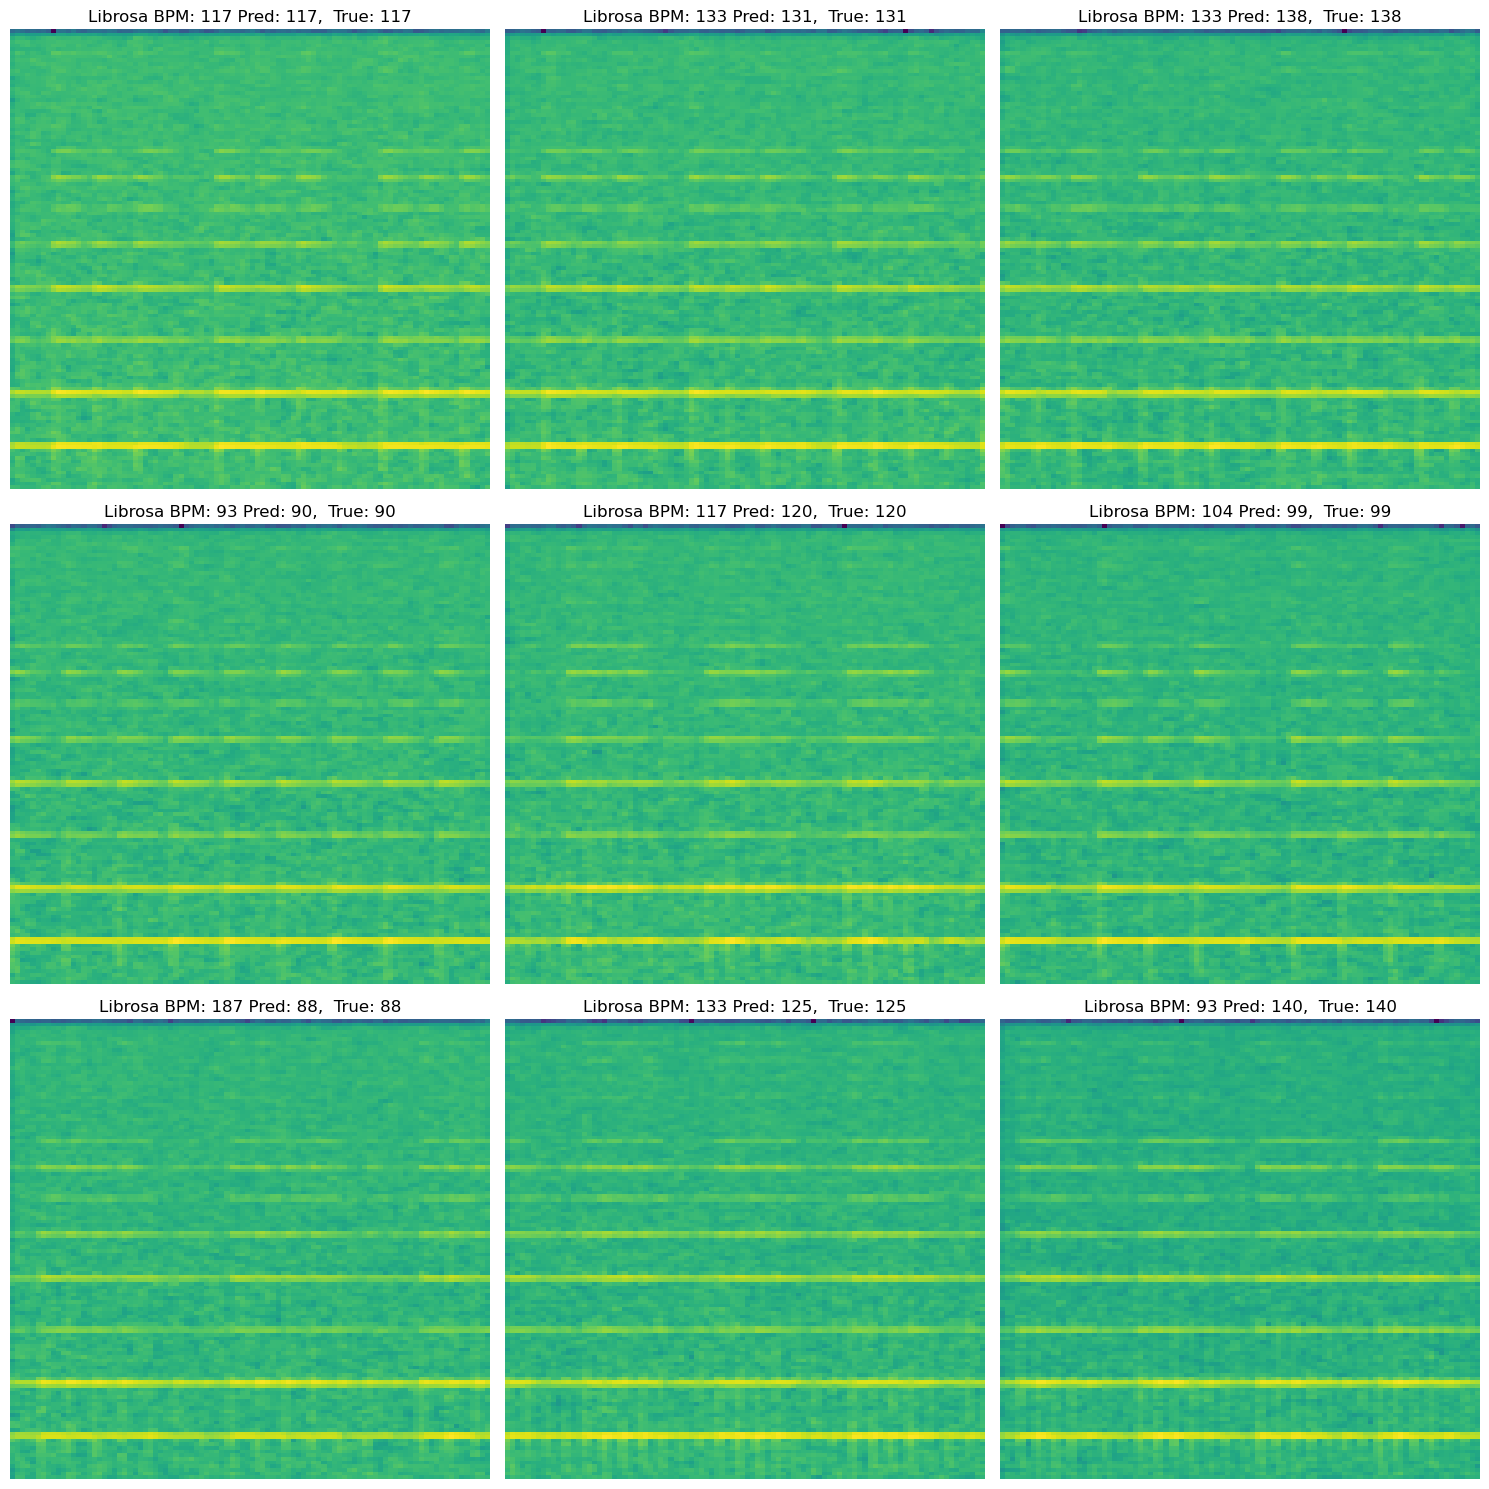

Model accuracy within ±1.0 BPM: 98.21%, Librosa accuracy within ±1.0 BPM: 14.62%


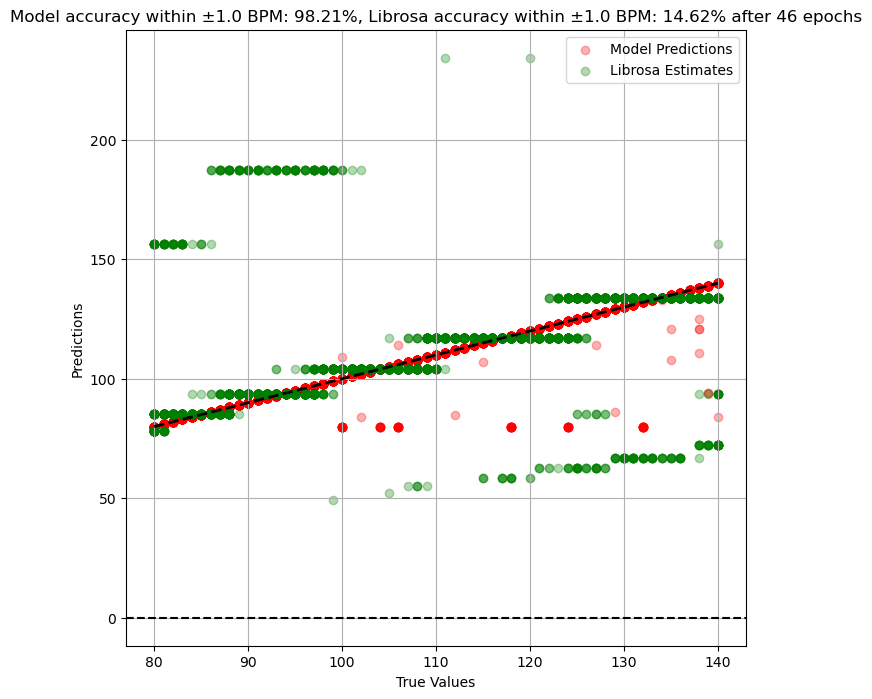

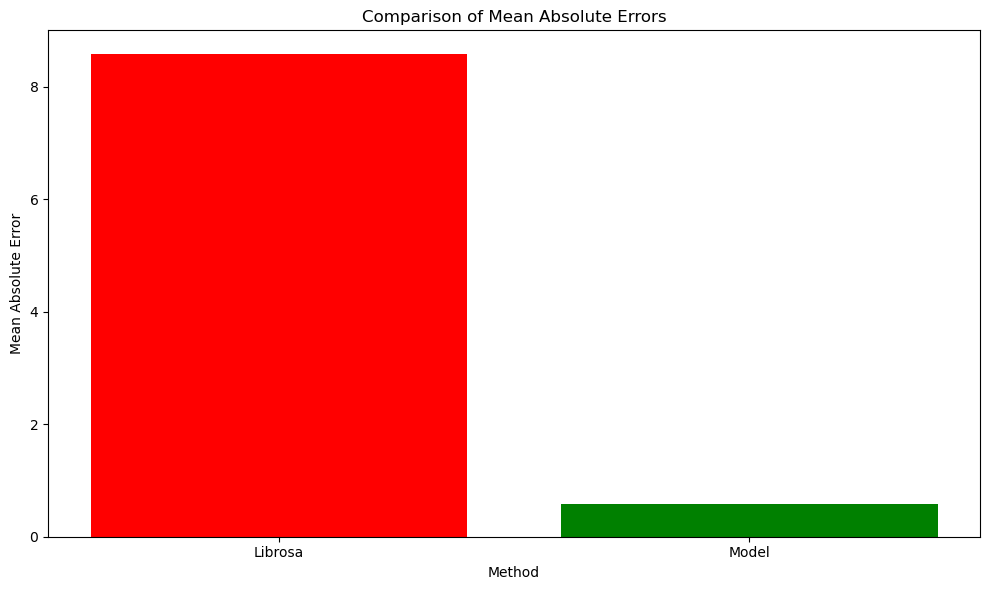

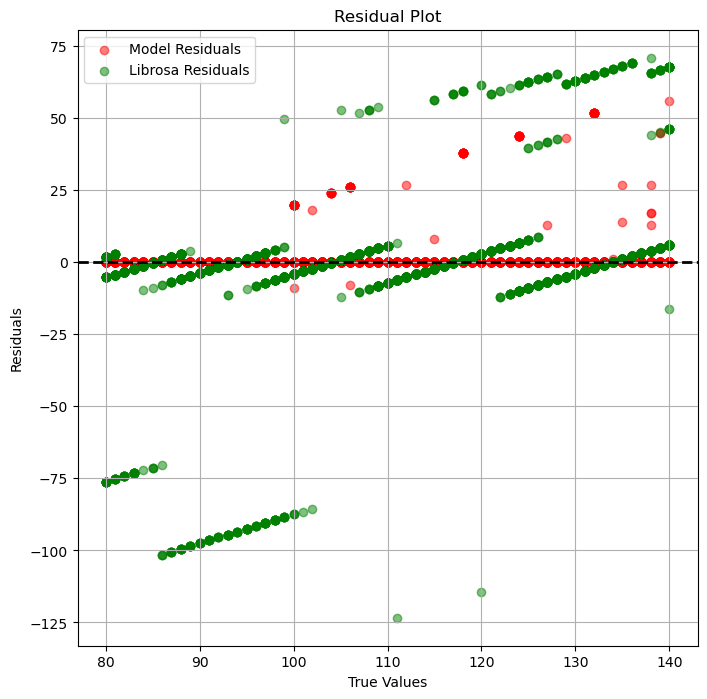

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

def correct_octave_error(predictions, true_values):
        # If the inputs are not iterable (lists or arrays), wrap them in a list.
    corrected_predictions = []
        
    for pred, true in zip(predictions, true_values):
        half_pred = pred / 2
        double_pred = pred * 2
        
        error_original = abs(true - pred)
        error_half = abs(true - half_pred)
        error_double = abs(true - double_pred)
        
        if error_half < error_original:
            corrected_predictions.append(half_pred)
        elif error_double < error_original:
            corrected_predictions.append(double_pred)
        else:
            corrected_predictions.append(pred)
            
    return np.array(corrected_predictions)

model.eval()
data, targets, librosa_bpm = next(iter(train_loader))
outputs, _ = model(data)
predictions = torch.argmax(outputs, dim=1) + 80
#predictions = outputs

fig, axarr = plt.subplots(3, 3, figsize=(15, 15))  # create a 3x3 grid of plots

for i in range(3):
    for j in range(3):
        idx = i * 3 + j  # get the current index in the batch
        
        # plot mel spectrogram
        mel_data = data[idx].squeeze(0)
        axarr[i, j].imshow(librosa.power_to_db(mel_data, ref=np.max), origin='lower', aspect='auto')
        #corrected_pred = correct_octave_error([int(predictions[idx])], [int(targets[idx])])
        axarr[i, j].set_title(f"Librosa BPM: {int(librosa_bpm[idx])} Pred: {int(predictions[idx])},  True: {int(targets[idx])}")
        axarr[i, j].axis('off')  # hide axis

plt.tight_layout()
plt.show()


# Set model to evaluation mode
model.eval()

all_predictions = []
all_true_labels = []
librosa_bpm_estimates = []  # List to store Librosa's BPM estimates

val_syn_loader = DataLoader(val_set_syn, batch_size=128, shuffle=True, drop_last=False)

# No gradient is needed during evaluation/inference
cnt = 0
with torch.no_grad():
    for data, target, librosa_bpm in val_syn_loader:
        outputs, _ = model(data)
        predictions = torch.argmax(outputs, dim=1) + 80
        all_predictions.extend(predictions.cpu().numpy()) 
        all_true_labels.extend(target.cpu().numpy())
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())
        



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)

# Korrigiere die Vorhersagen für das Modell und Librosa
all_predictions_corrected = correct_octave_error(all_predictions, all_true_labels)
librosa_bpm_estimates_corrected = correct_octave_error(librosa_bpm_estimates, all_true_labels)


# unique_time_sigs = set(all_genre)
# for time_sig in unique_time_sigs:
#     print(time_sig, "\n")

 #sub_dirs = ['1_4', '2_4', '3_4', '4_4', '5_4', '7_8']

time_signature_colors = {
    # 0 : 'red',
    # 1 : 'blue',
    # 2 : 'yellow',
    # 3 : 'purple',
    # 4 : 'cyan',
    # 5 : 'black',    # ... add other time signatures as needed
    # 6 : 'black',    # ... add other time signatures as needed
    # 7 : 'black',    # ... add other time signatures as needed
    # 8 : 'black',    # ... add other time signatures as needed
    # 9 : 'black',    # ... add other time signatures as needed
    # 10 : 'black',    # ... add other time signatures as needed
    0 : 'red',
    1 : 'red',
    2 : 'red',
    3 : 'red',
    4 : 'red',
    5 : 'red',    # ... add other time signatures as needed
    6 : 'red',    # ... add other time signatures as needed
    7 : 'red',    # ... add other time signatures as needed
    8 : 'red',    # ... add other time signatures as needed
    9 : 'red',    # ... add other time signatures as needed
    10 : 'red',    # ... add other time signatures as needed
}


# Residual plot
model_residuals = all_true_labels - all_predictions
librosa_residuals = all_true_labels - librosa_bpm_estimates  # Residuals for Librosa's BPM estimates

# # Calculate the linear fit for model's residuals
# from sklearn.linear_model import LinearRegression

# # Training a linear regressor on original predictions to predict residuals
# calibration_model = LinearRegression()
# calibration_model.fit(all_predictions.reshape(-1, 1), model_residuals)

# # Adjust predictions
# adjustment = calibration_model.predict(all_predictions.reshape(-1, 1))
# print(f"Adjustment: {adjustment.mean():.2f}")
# adjusted_predictions = all_predictions + adjustment






# model_mae = np.mean(np.abs(model_residuals))
# librosa_mae = np.mean(np.abs(librosa_residuals))

# labels = ['Model', 'Librosa']
# errors = [model_mae, librosa_mae]

# plt.figure(figsize=(8, 6))
# plt.bar(labels, errors, color=['red', 'green'])
# plt.xlabel('Method')
# plt.ylabel('Mean Absolute Error')
# plt.title('Comparison of Mean Absolute Errors')
# plt.show()

tolerance = 1.0  # Define your acceptable range e.g., if you want predictions within 5 BPM of true value, set X to 5.
correct_predictions = np.abs(all_true_labels - all_predictions) <= tolerance
correct_predictions_lib = np.abs(all_true_labels - librosa_bpm_estimates) <= tolerance
accuracy = np.mean(correct_predictions) * 100  # This gives the percentage of predictions within the defined range.
accuracy_lib = np.mean(correct_predictions_lib) * 100  # This gives the percentage of predictions within the defined range.
print(f"Model accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")

# adjusted_predictions = all_predictions - expected_residuals

# Scatter plot
plt.figure(figsize=(8, 8))
# plt.scatter(all_true_labels, adjusted_predictions, alpha=0.3, color="b", label='Adjusted Model Predictions')
plt.scatter(all_true_labels, all_predictions, color='red', alpha=0.3, label='Model Predictions')
plt.scatter(all_true_labels, librosa_bpm_estimates, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
plt.plot([all_true_labels.min(), all_true_labels.max()], 
         [all_true_labels.min(), all_true_labels.max()], 
         'k--', lw=2)
# plt.plot(x, y, 'b--', label='Fit Line')
# plt.scatter(all_true_labels, model_residuals, alpha=0.5, color='r', label='Model Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f"Model accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}% after {len(epoch_losses)} epochs")
plt.legend()
plt.grid(True)
plt.show()

# tolerance_corrected = 10.0  # Define your acceptable range e.g., if you want predictions within 5 BPM of true value, set X to 5.
# correct_predictions_corrected = np.abs(all_true_labels - all_predictions_corrected) <= tolerance
# correct_predictions_corrected_lib = np.abs(all_true_labels - librosa_bpm_estimates_corrected) <= tolerance
# accuracy_corrected = np.mean(correct_predictions_corrected) * 100  # This gives the percentage of predictions within the defined range.
# accuracy_lib_corrected = np.mean(correct_predictions_corrected_lib) * 100  # This gives the percentage of predictions within the defined range.
# print(f"Model accuracy within ±{tolerance_corrected} BPM: {accuracy_corrected:.2f}%, Librosa accuracy within ±{tolerance_corrected} BPM: {accuracy_lib_corrected:.2f}%")

# # adjusted_predictions = all_predictions - expected_residuals

# # Scatter plot
# plt.figure(figsize=(8, 8))
# # plt.scatter(all_true_labels, adjusted_predictions, alpha=0.3, color="b", label='Adjusted Model Predictions')
# plt.scatter(all_true_labels, all_predictions_corrected, color='red', alpha=0.3, label='Model Predictions (octave corrected))')
# plt.scatter(all_true_labels, librosa_bpm_estimates_corrected, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
# plt.plot([all_true_labels.min(), all_true_labels.max()], 
#          [all_true_labels.min(), all_true_labels.max()], 
#          'k--', lw=2)
# # plt.plot(x, y, 'b--', label='Fit Line')
# # plt.scatter(all_true_labels, model_residuals, alpha=0.5, color='r', label='Model Residuals')
# plt.axhline(y=0, color='k', linestyle='--')
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.title(f"Model (octave corrected) accuracy within ±{tolerance_corrected} BPM: {accuracy_corrected:.2f}%, Librosa accuracy within ±{tolerance_corrected} BPM: {accuracy_lib_corrected:.2f}% after {len(epoch_losses)} epochs")
# plt.legend()
# plt.grid(True)
# plt.show()

# Calculate Mean Absolute Errors
model_mae = np.mean(np.abs(all_true_labels - all_predictions))
librosa_mae = np.mean(np.abs(all_true_labels - librosa_bpm_estimates))
model_corrected_mae = np.mean(np.abs(all_true_labels - all_predictions_corrected))

# Plot Mean Absolute Errors
labels = ['Librosa', 'Model']
errors = [librosa_mae, model_mae]

plt.figure(figsize=(10, 6))
plt.bar(labels, errors, color=['red', 'green'])
plt.xlabel('Method')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Errors')
plt.tight_layout()
plt.show()



plt.figure(figsize=(8, 8))
plt.scatter(all_true_labels, model_residuals, alpha=0.5, color='red', label='Model Residuals')
plt.scatter(all_true_labels, librosa_residuals, alpha=0.5, color='green', label='Librosa Residuals')  # Plotting residuals for Librosa's BPM estimates in green
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()
